In [34]:
import sklearn
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import requests
from pathlib import Path


# Binary Cassificatation with scikit learn function
We will work with make_moons() function from scikit learn library to train a model on a binary classification task.

In [244]:
# Assinging the values of a function to a variable
x,y=make_moons(n_samples=1000, random_state=42)

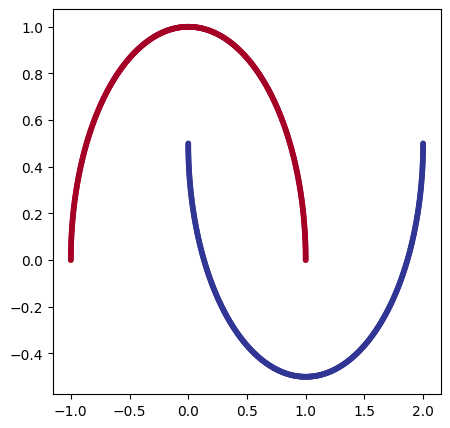

In [266]:
# Visualizing the data
plt.figure(figsize=(5, 5))
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='RdYlBu', s=10)


In [246]:
# Converting numpy arrays to a tensor type
x=torch.from_numpy(x).type(torch.float)
y=torch. from_numpy(y).type(torch.float)

In [247]:
# Listing first five of them
x[:5], y[:5]

(tensor([[ 0.0087,  0.3682],
         [ 0.9214, -0.4969],
         [ 0.9402, -0.4982],
         [ 0.4659, -0.3454],
         [-0.8504,  0.5261]]),
 tensor([1., 1., 1., 1., 0.]))

In [248]:
x.dtype, y.dtype

(torch.float32, torch.float32)

In [249]:
# Dividing the data inro training and testing
x_train, x_test, y_train, y_test=train_test_split(x,y,train_size=0.8, random_state=42)

len(x_train), len(x_test), len(y_train), len(y_test)

y_test.shape

torch.Size([200])

In [250]:
# Building a model
class MoonModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1=nn.Linear(in_features=2, out_features=6)
        self.activation=nn.ReLU() 
        self.layer_2=nn.Linear(in_features=6, out_features=1)

    def forward(self, x):
        return self.layer_2(self.activation(self.layer_1(x)))
    
model_0=MoonModelV0()

In [251]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323]])),
             ('layer_1.bias',
              tensor([ 0.5224,  0.0958,  0.3410, -0.0998,  0.5451,  0.1045])),
             ('layer_2.weight',
              tensor([[-0.1906,  0.1041, -0.1881, -0.0479, -0.1658,  0.2708]])),
             ('layer_2.bias', tensor([-0.3223]))])

In [252]:
# Instantiating loss fucntion and optimizer 
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [253]:
# Transferring model to run on GPU
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [254]:
# Creating logits of probabilities
model_0.eval()
with torch.inference_mode():
    y_logits=model_0(x_test.to(device))

y_logits[:10]
y_logits.shape

torch.Size([200, 1])

In [255]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs=torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.3665],
        [0.3727],
        [0.3651],
        [0.3741],
        [0.3615]])

In [256]:
# Find the predicted labels
y_preds=torch.round(y_pred_probs)

y_pred_labels=torch.round(torch.sigmoid(model_0(x_test.to(device))))

# Get rid of extra dimension
y_preds.squeeze()

print(torch.eq(y_preds, y_pred_labels.squeeze()))

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])


In [257]:
# Creating a function for accuracy
def accuracy_fn(x_true, y_pred):
    correct=torch.eq(x_true, y_pred).sum().item()
    acc=(correct/len(y_pred))*100
    return acc

In [258]:
# Building a training and testing loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=100

x_train, y_train=x_train.to(device), y_train.to(device)
x_test, y_test=x_test.to(device), y_test.to(device)

for epoch in range(epochs):

    model_0.train()

    # forward pass
    y_logits=model_0(x_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logits))

    # calculate the loss
    loss=loss_fn(y_logits, y_train)
    acc=accuracy_fn(x_true=y_train, y_pred=y_pred)
    # optimizer zero grad
    optimizer.zero_grad()

    # backpropogation
    loss.backward()

    # gradient descent
    optimizer.step()


    #testing
    model_0.eval()
    with torch.inference_mode():
        #forwards pass
        test_logits=model_0(x_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logits))
        #calculate the loss
        test_loss=loss_fn(test_logits, y_test)
        test_acc=accuracy_fn(x_true=y_test, y_pred=test_pred)
        # print
    if epoch % 10 == 0:
        print(f"Epoch:{epoch}, Loss:{loss:.5f}, Acc:{acc:.2f}%, test loss:{test_loss:.5f}, Test acc:{test_acc:.2f}%")



Epoch:0, Loss:0.74066, Acc:50.00%, test loss:0.73777, Test acc:50.00%
Epoch:10, Loss:0.72020, Acc:50.00%, test loss:0.71879, Test acc:50.00%
Epoch:20, Loss:0.70208, Acc:50.00%, test loss:0.70205, Test acc:50.00%
Epoch:30, Loss:0.68592, Acc:50.00%, test loss:0.68718, Test acc:50.00%
Epoch:40, Loss:0.67143, Acc:50.00%, test loss:0.67391, Test acc:50.00%
Epoch:50, Loss:0.65846, Acc:50.00%, test loss:0.66207, Test acc:50.00%
Epoch:60, Loss:0.64669, Acc:67.00%, test loss:0.65136, Test acc:66.50%
Epoch:70, Loss:0.63592, Acc:72.75%, test loss:0.64158, Test acc:73.00%
Epoch:80, Loss:0.62598, Acc:76.12%, test loss:0.63259, Test acc:76.00%
Epoch:90, Loss:0.61676, Acc:76.62%, test loss:0.62426, Test acc:77.50%


In [259]:
# Evaluation of model perfomance

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


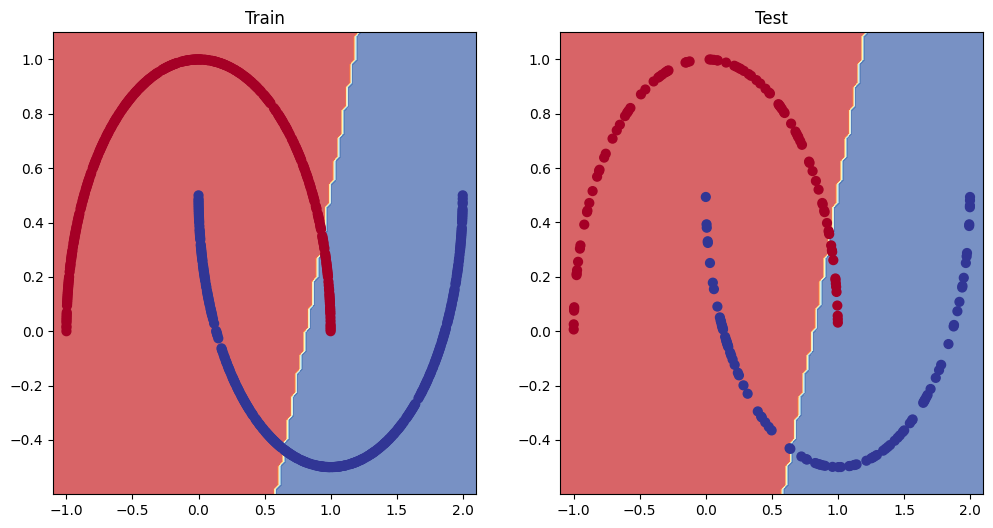

In [265]:
# Plot the decision boundaries to see how the model distinguishes colors
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, x_test, y_test) 